### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
import warnings

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)

from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

2023-07-31 19:20:00.177764: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 19:20:00.220673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-31 19:20:00.221974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 19:20:01.233018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Datasets

In [3]:
test = pd.read_csv("test_dataset.csv")
train = pd.read_csv("training_dataset.csv")
validation = pd.read_csv("validation_dataset.csv")

In [4]:
Cover_Type_Labels = [
    "Spruce",
    "Lodgepole",
    "Ponderosa",
    "Willow",
    "Aspen",
    "Douglas",
    "Krummholz",
]

### Data Cleaning

In [5]:
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)
validation.drop("Id", axis=1, inplace=True)

### Functions

In [6]:
def plot_best_n(
    n_range: list,
    test_acc_scores: list,
    val_acc_scores: list,
    value: str = "Features",
    classifier: str = "Classifier",
    baseline: float = None,
    baseline_name: str = None,
):
    """Plots the best number of features for a given classifier

    Parameters
    ----------
    n_range : list
        List of number of features
    test_acc_scores : list
        List of test accuracy scores
    val_acc_scores : list
        List of validation accuracy scores
    value : str, optional
        The value to be plotted, by default "Features"
    classifier : str, optional
        The classifier used, by default "Classifier"
    baseline : float, optional
        The baseline model accuracy score, by default None
    baseline_name : str, optional
        The name of the baseline model, by default None
    """
    print(f"Best Test Accuracy Score: {max(test_acc_scores)}")
    print(f"Best Validation Accuracy Score: {max(val_acc_scores)}")
    print(f"Best Number of {value} (acc): {n_range[np.argmax(test_acc_scores)]}")

    plt.figure(figsize=(6, 4))
    if baseline:
        plt.axhline(
            baseline, label=f"{baseline_name} Baseline", color="red", linestyle="--"
        )
    plt.plot(n_range, test_acc_scores, label="Accuracy Score", color="green")
    plt.plot(n_range, val_acc_scores, label="Validation Score", color="blue")
    plt.scatter(
        n_range[np.argmax(test_acc_scores)],
        max(test_acc_scores),
        marker="x",
        color="green",
    )
    plt.scatter(
        n_range[np.argmax(val_acc_scores)],
        max(val_acc_scores),
        marker="x",
        color="blue",
    )
    plt.annotate(
        f"({n_range[np.argmax(test_acc_scores)]}, {max(test_acc_scores):.3f})",
        xy=(n_range[np.argmax(test_acc_scores)], max(test_acc_scores)),
    )
    plt.annotate(
        f"({n_range[np.argmax(val_acc_scores)]}, {max(val_acc_scores):.3f})",
        xy=(n_range[np.argmax(val_acc_scores)], max(val_acc_scores)),
    )
    plt.legend()
    plt.title(f"Accuracy Scores vs {value} ({classifier})")
    plt.xlabel(value)
    plt.ylabel("Accuracy Score")
    plt.show()

In [15]:
def plot_cm(
    y_test,
    y_test_pred,
    y_val,
    y_val_pred,
    model_name,
    _feature_engineering=None,
):
    """Plot confusion matrices for test and validation sets.

    Parameters
    ----------
    y_test : array-like
        True labels for test set.
    y_test_pred : array-like
        Predicted labels for test set.
    y_val : array-like
        True labels for validation set.
    y_val_pred : array-like
        Predicted labels for validation set.
    model_name : str
        Name of model.
    _feature_engineering : str, optional
        Name of feature engineering method, by default None.
    """
    print(
        f"{model_name} w/ VT Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}"
    )
    print(
        f"{model_name} w/ VT Val Accuracy: {accuracy_score(y_val, y_val_pred):.3f}"
    )

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    ax1 = sns.heatmap(
        confusion_matrix(y_test, y_test_pred),
        annot=True,
        cmap="Greens",
        fmt="d",
        xticklabels=Cover_Type_Labels,
        yticklabels=Cover_Type_Labels,
        ax=axes[0],
    )
    ax1.set_title(
        f"Test Confusion Matrix ({model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''})"
    )
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")

    ax2 = sns.heatmap(
        confusion_matrix(y_val, y_val_pred),
        annot=True,
        cmap="Greens",
        fmt="d",
        xticklabels=Cover_Type_Labels,
        yticklabels=Cover_Type_Labels,
        ax=axes[1],
    )
    ax2.set_title(
        f"Validation Confusion Matrix ({model_name}{' w/ ' + _feature_engineering if _feature_engineering else ''})"
    )
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Actual")

    plt.show()

## Models

In [8]:
models = [
    KNeighborsClassifier(),
    svm.SVC(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    GaussianNB(),
]

model_names = ["KNN", "SVM", "LR", "DT", "NB"]

In [9]:
X_train = train.drop("Cover_Type", axis=1)
y_train = train["Cover_Type"] - 1
X_test = test.drop("Cover_Type", axis=1)
y_test = test["Cover_Type"] - 1
X_val = validation.drop("Cover_Type", axis=1)
y_val = validation["Cover_Type"] - 1

### Baseline (Q1)

KNN => Test:0.738, Val:0.752
SVM => Test:0.561, Val:0.550
LR => Test:0.474, Val:0.477
DT => Test:0.763, Val:0.756
NB => Test:0.601, Val:0.599


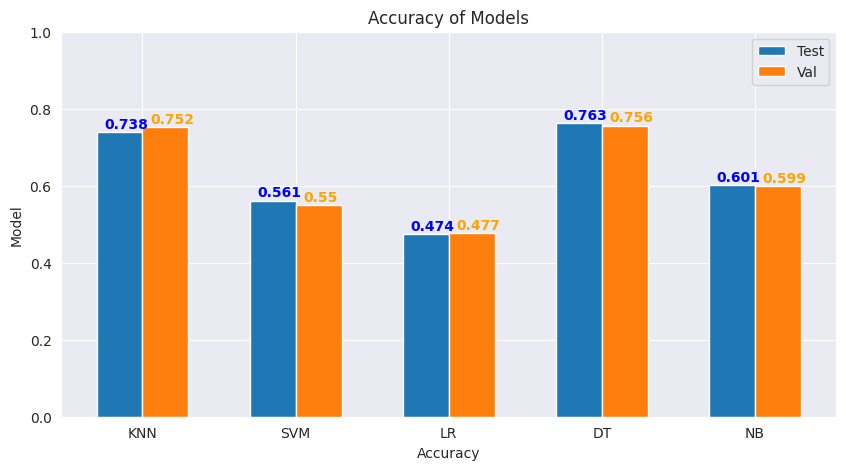

In [10]:
baseline_accuracy = dict.fromkeys(model_names)

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    baseline_accuracy[name] = (test_acc, val_acc)
    print(f"{name} => Test:{test_acc:.3f}, Val:{val_acc:.3f}")

plt.figure(figsize=(10, 5))
plt.bar(
    np.arange(len(model_names)),
    [baseline_accuracy[name][0] for name in model_names],
    width=0.3,
    label="Test",
)
plt.bar(
    np.arange(len(model_names)) + 0.3,
    [baseline_accuracy[name][1] for name in model_names],
    width=0.3,
    label="Val",
)
plt.xticks(np.arange(len(model_names)) + 0.3 / 2, model_names)
for i, v in enumerate(model_names):
    plt.text(
        i - 0.1,
        baseline_accuracy[v][0] + 0.01,
        str(round(baseline_accuracy[v][0], 3)),
        color="blue",
        fontweight="bold",
    )
    plt.text(
        i + 0.2,
        baseline_accuracy[v][1] + 0.01,
        str(round(baseline_accuracy[v][1], 3)),
        color="orange",
        fontweight="bold",
    )
plt.legend()
plt.title("Accuracy of Models")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.ylim(0, 1)
plt.show()

KNN w/ VT Test Accuracy: 0.738
KNN w/ VT Val Accuracy: 0.752


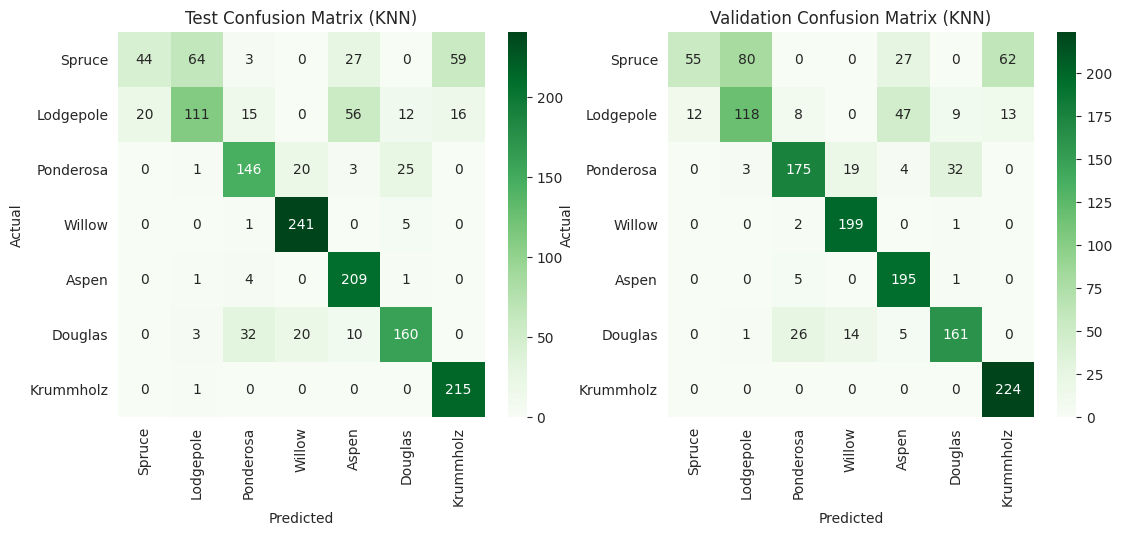

SVM w/ VT Test Accuracy: 0.561
SVM w/ VT Val Accuracy: 0.550


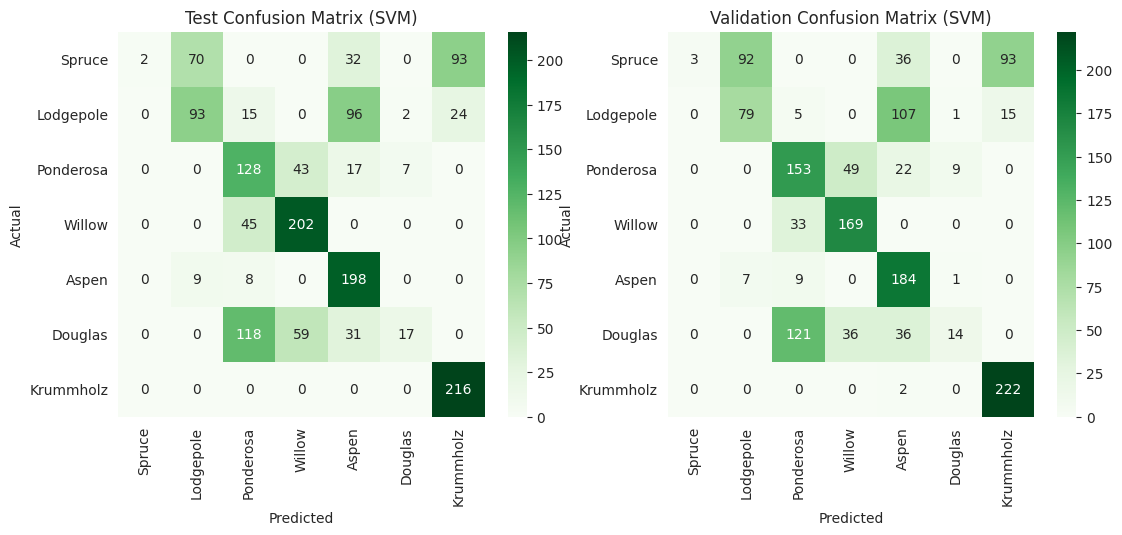

LR w/ VT Test Accuracy: 0.474
LR w/ VT Val Accuracy: 0.477


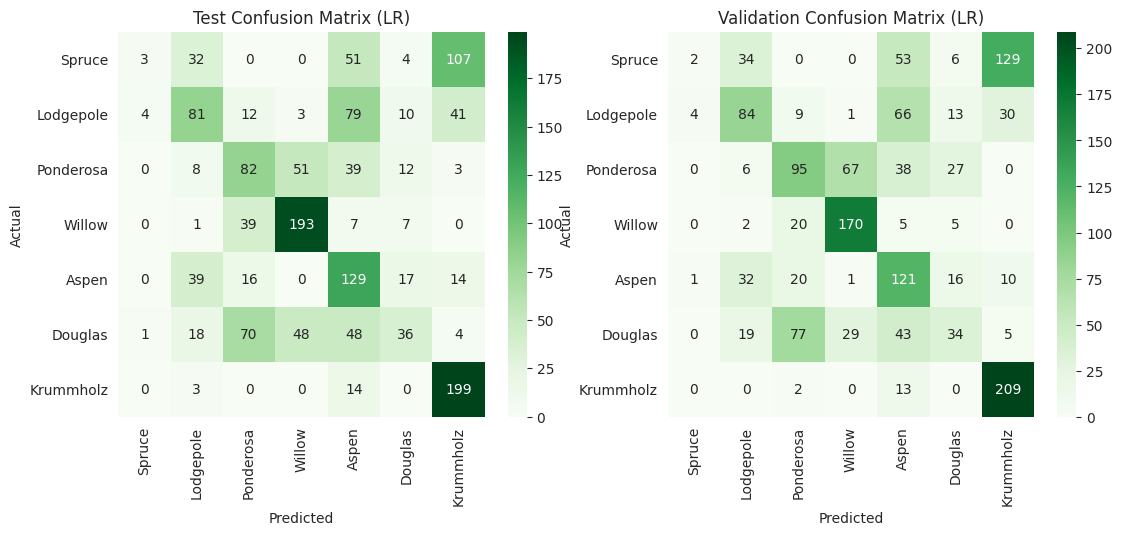

DT w/ VT Test Accuracy: 0.755
DT w/ VT Val Accuracy: 0.756


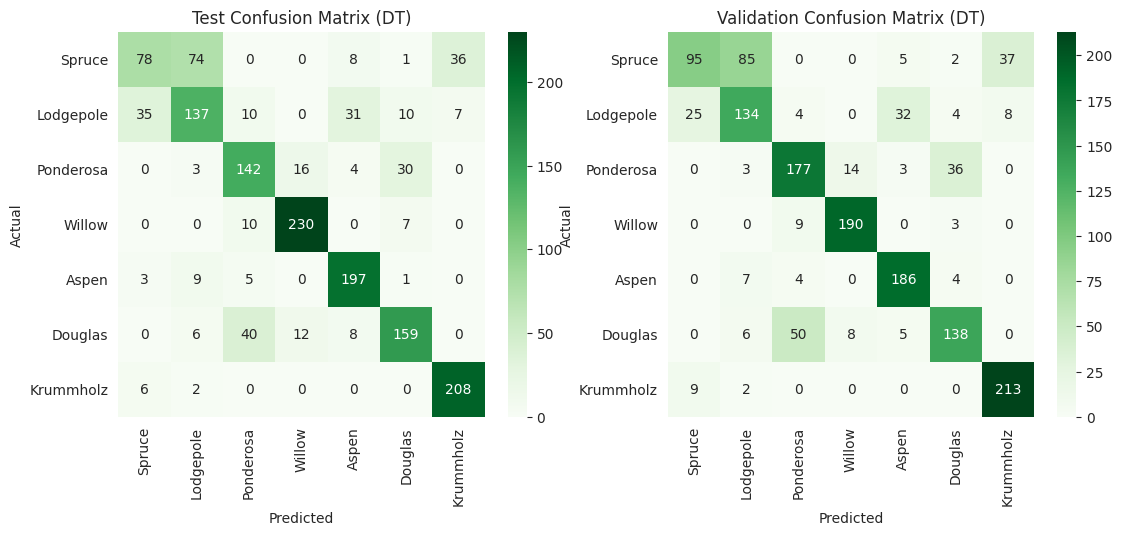

NB w/ VT Test Accuracy: 0.601
NB w/ VT Val Accuracy: 0.599


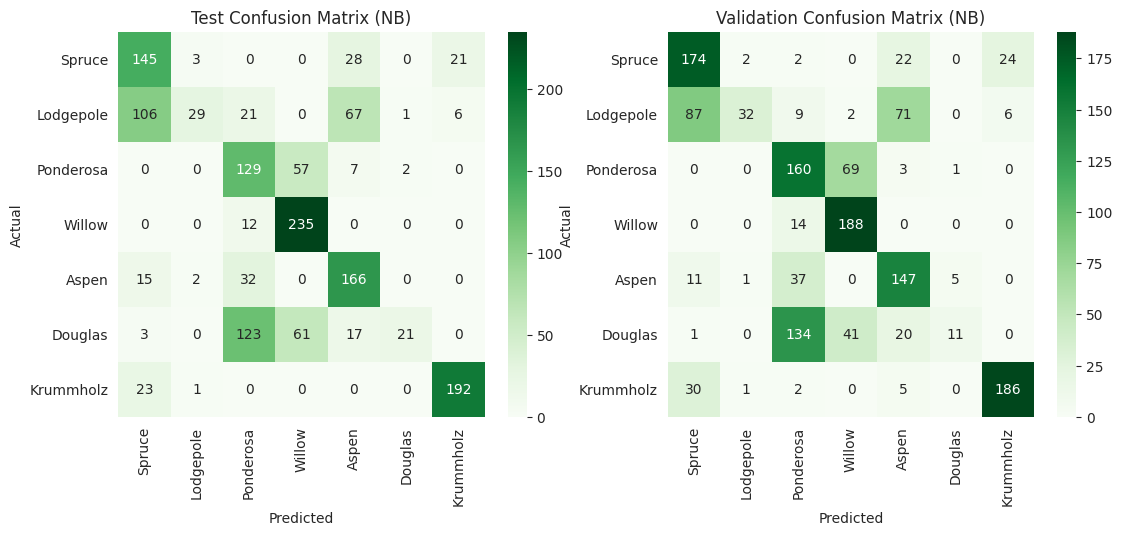

In [16]:
# Plotting the confusion matrix for the Five models used in the project
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_val = model.predict(X_val)
    plot_cm(y_test, y_pred_test, y_val, y_pred_val, model_name=name)



Best models are KNN (.738) and Decision Tree (.764)

## Feature Engineering

### Sampling

### First Improvement (Q2)

#### Filter Method, Variance Threshold

Best Test Accuracy Score: 0.7383606557377049
Best Validation Accuracy Score: 0.7523364485981309
Best Number of Threshold (acc): 0.0


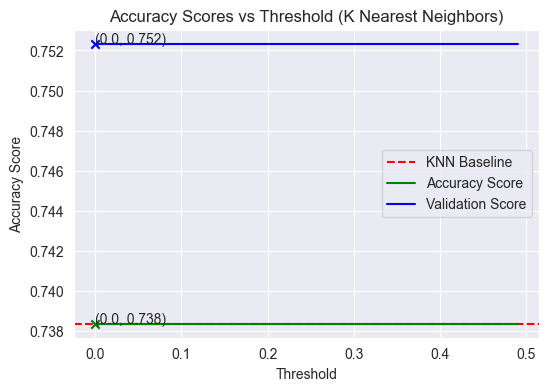

In [9]:
threshold_range = np.arange(0.0, 0.5, 0.01)
test_acc_scores = []
val_acc_scores = []
for thresh in threshold_range:
    vt = VarianceThreshold(threshold=thresh)
    vt.fit(X_train)
    X_train_vt = vt.transform(X_train)
    X_test_vt = vt.transform(X_test)
    X_val_vt = vt.transform(X_val)

    model = KNeighborsClassifier()
    model.fit(X_train_vt, y_train)
    test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_vt)))
    val_acc_scores.append(accuracy_score(y_val, model.predict(X_val_vt)))

plot_best_n(
    threshold_range,
    test_acc_scores,
    val_acc_scores,
    value="Threshold",
    classifier="K Nearest Neighbors",
    baseline=baseline_accuracy["KNN"][0],
    baseline_name="KNN",
)

Best Test Accuracy Score: 0.7691803278688525
Best Validation Accuracy Score: 0.7656875834445928
Best Number of Threshold (acc): 0.046


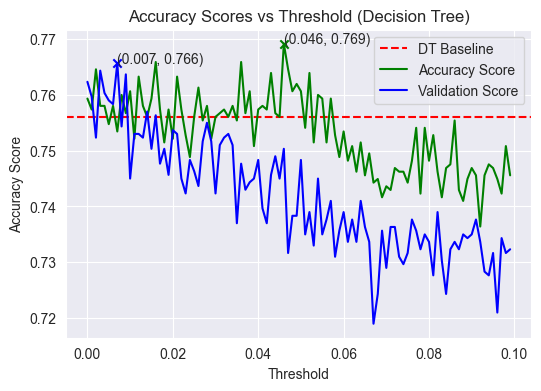

In [15]:
threshold_range = np.arange(0.0, 0.1, 0.001)
model = DecisionTreeClassifier()
test_acc_scores = []
val_acc_scores = []
for thresh in threshold_range:
    vt = VarianceThreshold(threshold=thresh)
    vt.fit(X_train)
    X_train_vt = vt.transform(X_train)
    X_test_vt = vt.transform(X_test)
    X_val_vt = vt.transform(X_val)

    model.fit(X_train_vt, y_train)
    test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_vt)))
    val_acc_scores.append(accuracy_score(y_val, model.predict(X_val_vt)))

plot_best_n(
    threshold_range,
    test_acc_scores,
    val_acc_scores,
    value="Threshold",
    classifier="Decision Tree",
    baseline=baseline_accuracy["DT"][0],
    baseline_name="DT",
)

#### Wrapper Method, Recursive Feature Elimination

In [11]:
def knn_feature_importance(estimator):
    distances = estimator.kneighbors(None, n_neighbors=1)
    distances = np.sort(distances, axis=1)
    importances = 1 - distances[:, 0]
    return importances

Best Test Accuracy Score: 0.7383606557377049
Best Validation Accuracy Score: 0.7523364485981309
Best Number of Features (acc): 54


<Figure size 600x400 with 0 Axes>

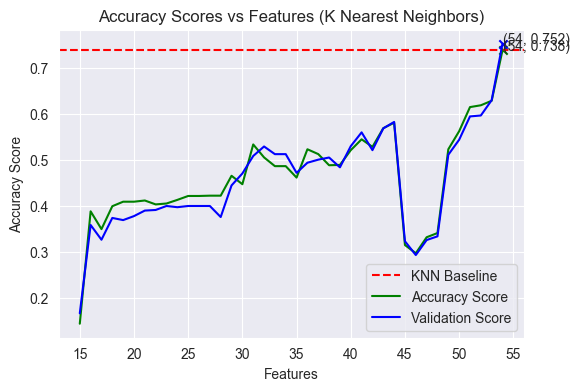

In [13]:
n_features_range = np.arange(15, len(X_train.columns) + 1)
test_acc_scores = []
val_acc_scores = []

for n_features in n_features_range:
    estimator = KNeighborsClassifier()
    rfe = RFE(
        estimator,
        n_features_to_select=n_features,
        importance_getter=knn_feature_importance,
        step=10,
    )

    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    estimator.fit(X_train[selected_features], y_train)
    test_acc_scores.append(
        accuracy_score(y_test, estimator.predict(X_test[selected_features]))
    )
    val_acc_scores.append(
        accuracy_score(y_val, estimator.predict(X_val[selected_features]))
    )

# plot baseline accuracy
plt.figure(figsize=(6, 4))
plot_best_n(
    n_features_range,
    test_acc_scores,
    val_acc_scores,
    classifier="K Nearest Neighbors",
    baseline=baseline_accuracy["KNN"][0],
    baseline_name="KNN",
)

Best Test Accuracy Score: 0.7665573770491804
Best Validation Accuracy Score: 0.7690253671562083
Best Number of Features (acc): 17


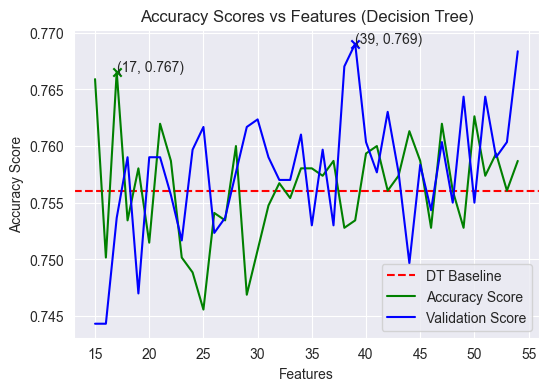

In [14]:
n_features_range = np.arange(15, len(X_train.columns) + 1)
test_acc_scores = []
val_acc_scores = []

for n_features in n_features_range:
    estimator = DecisionTreeClassifier()
    rfe = RFE(
        estimator,
        n_features_to_select=n_features,
    )

    rfe.fit(X_train, y_train)
    selected_features = X_train.columns[rfe.support_]
    estimator.fit(X_train[selected_features], y_train)
    test_acc_scores.append(
        accuracy_score(y_test, estimator.predict(X_test[selected_features]))
    )
    val_acc_scores.append(
        accuracy_score(y_val, estimator.predict(X_val[selected_features]))
    )

plot_best_n(
    n_features_range,
    test_acc_scores,
    val_acc_scores,
    classifier="Decision Tree",
    baseline=baseline_accuracy["DT"][0],
    baseline_name="DT",
)

Best models are Decision Tree w/ RFE n = 41 (0.765) and Decision Tree w/ VT threshold = .05 (.764)

### Second Improvement (Q3)

In [57]:
ensemble_models = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

ensemble_model_names = ["RF", "AB", "GB"]

RF => Test:0.818, Val:0.808
AB => Test:0.344, Val:0.356
GB => Test:0.768, Val:0.780


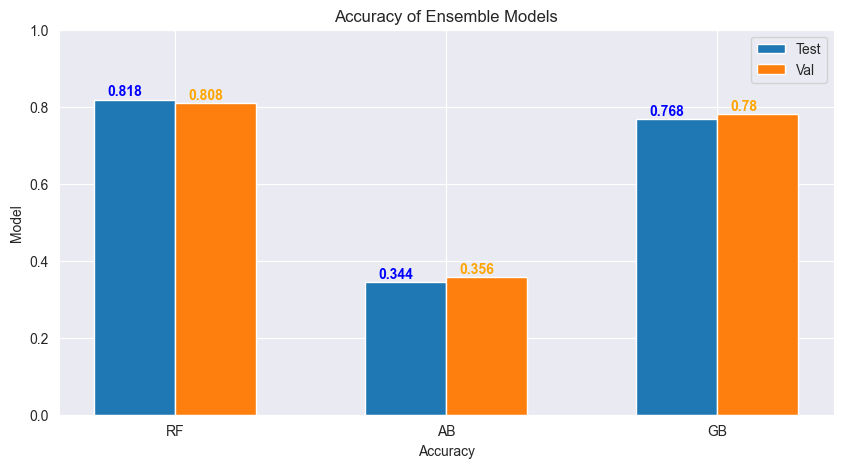

In [58]:
ensemble_baseline_accuracy = dict.fromkeys(ensemble_model_names)

for model, name in zip(ensemble_models, ensemble_model_names):
    model.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, model.predict(X_test))
    val_acc = accuracy_score(y_val, model.predict(X_val))
    ensemble_baseline_accuracy[name] = (test_acc, val_acc)
    print(f"{name} => Test:{test_acc:.3f}, Val:{val_acc:.3f}")

plt.figure(figsize=(10, 5))
plt.bar(
    np.arange(len(ensemble_model_names)),
    [ensemble_baseline_accuracy[name][0] for name in ensemble_model_names],
    width=0.3,
    label="Test",
)
plt.bar(
    np.arange(len(ensemble_model_names)) + 0.3,
    [ensemble_baseline_accuracy[name][1] for name in ensemble_model_names],
    width=0.3,
    label="Val",
)
plt.xticks(np.arange(len(ensemble_model_names)) + 0.3 / 2, ensemble_model_names)
for i, v in enumerate(ensemble_model_names):
    plt.text(
        i - 0.1,
        ensemble_baseline_accuracy[v][0] + 0.01,
        str(round(ensemble_baseline_accuracy[v][0], 3)),
        color="blue",
        fontweight="bold",
    )
    plt.text(
        i + 0.2,
        ensemble_baseline_accuracy[v][1] + 0.01,
        str(round(ensemble_baseline_accuracy[v][1], 3)),
        color="orange",
        fontweight="bold",
    )
plt.legend()
plt.title("Accuracy of Ensemble Models")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.ylim(0, 1)
plt.show()

#### Confusion Matrices

DecisionTreeClassifier w/ VT Test Accuracy: 0.756
DecisionTreeClassifier w/ VT Val Accuracy: 0.744


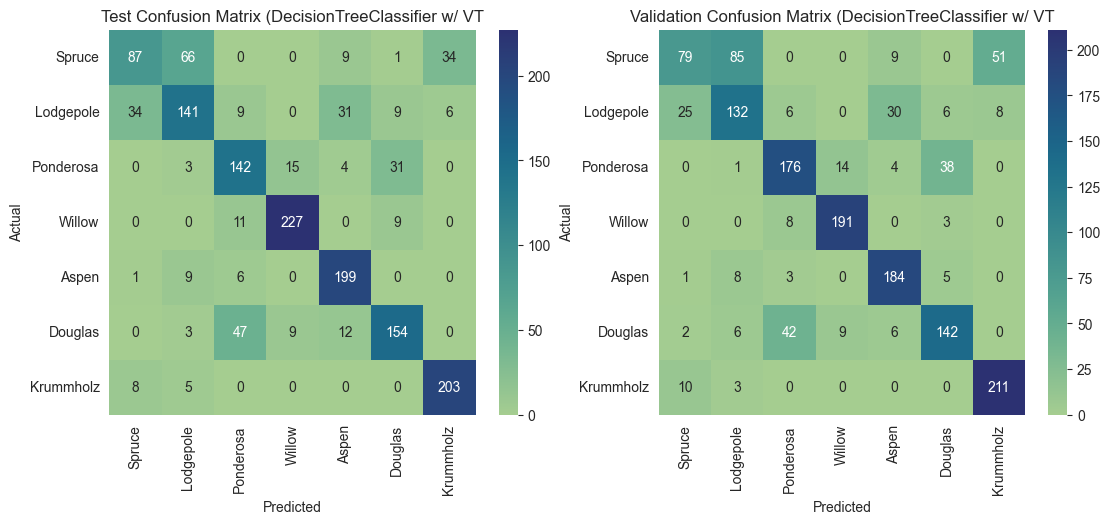

In [17]:
model = DecisionTreeClassifier()
vt = VarianceThreshold(threshold=0.04)
vt.fit(X_train)
X_train_vt = vt.transform(X_train)
X_test_vt = vt.transform(X_test)
X_val_vt = vt.transform(X_val)
model.fit(X_train_vt, y_train)
plot_cm(
    y_test,
    model.predict(X_test_vt),
    y_val,
    model.predict(X_val_vt),
    model.__class__.__name__,
    "VT",
)

DecisionTreeClassifier w/ RFE Test Accuracy: 0.759
DecisionTreeClassifier w/ RFE Val Accuracy: 0.758


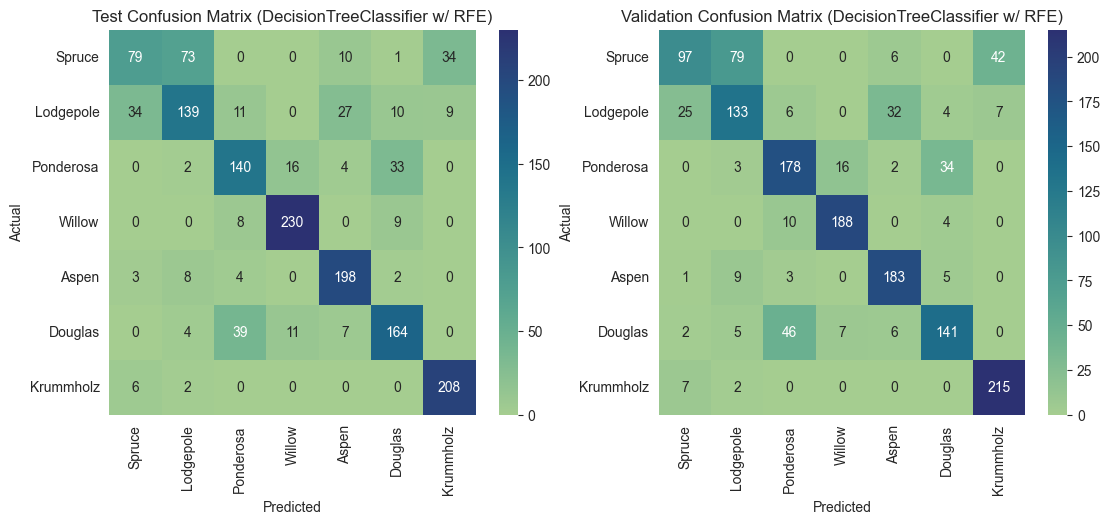

In [45]:
model = DecisionTreeClassifier()
rfe = RFE(model, n_features_to_select=47)
rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
model.fit(X_train[selected_features], y_train)
plot_cm(
    y_test,
    model.predict(X_test_vt),
    y_val,
    model.predict(X_val_vt),
    model.__class__.__name__,
    "VT",
)

RandomForestClassifier Test Accuracy: 0.8052459016393443
RandomForestClassifier Val Accuracy: 0.8104138851802403


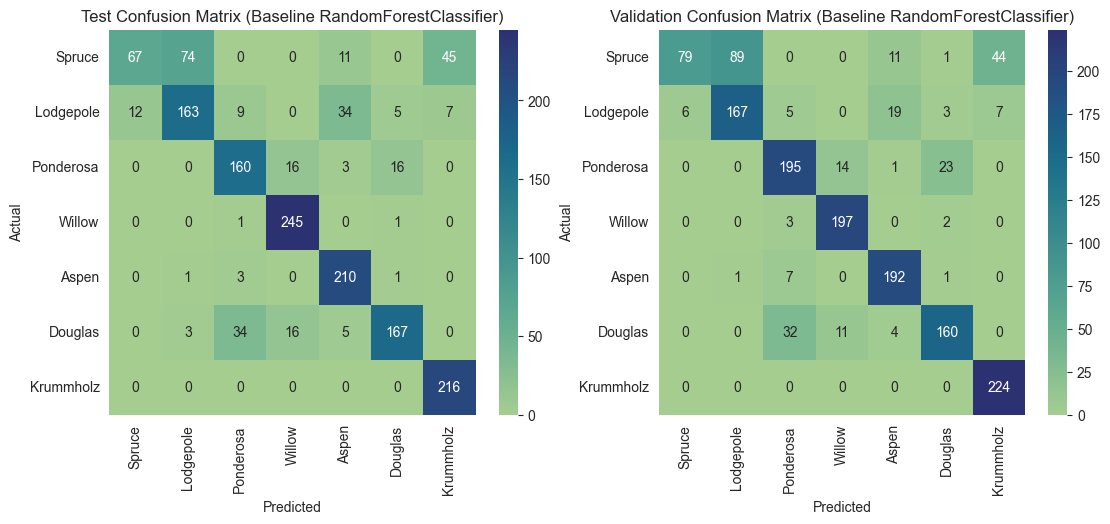

In [46]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
print(f"{model.__class__.__name__} Test Accuracy: {model.score(X_test, y_test)}")
print(f"{model.__class__.__name__} Val Accuracy: {model.score(X_val, y_val)}")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax1 = sns.heatmap(
    confusion_matrix(y_test, model.predict(X_test)),
    annot=True,
    cmap="crest",
    fmt="d",
    xticklabels=Cover_Type_Labels,
    yticklabels=Cover_Type_Labels,
    ax=axes[0],
)
ax1.set_title(f"Test Confusion Matrix (Baseline {model.__class__.__name__})")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

ax2 = sns.heatmap(
    confusion_matrix(y_val, model.predict(X_val)),
    annot=True,
    cmap="crest",
    fmt="d",
    xticklabels=Cover_Type_Labels,
    yticklabels=Cover_Type_Labels,
    ax=axes[1],
)
ax2.set_title(f"Validation Confusion Matrix (Baseline {model.__class__.__name__})")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.show()

GradientBoostingClassifier Test Accuracy: 0.7685245901639344
GradientBoostingClassifier Val Accuracy: 0.780373831775701


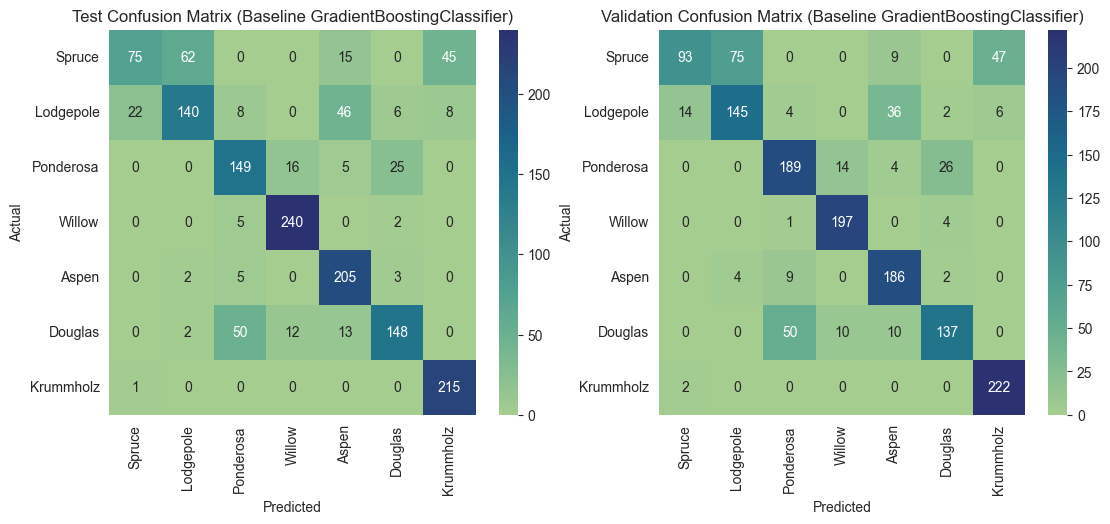

In [47]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print(f"{model.__class__.__name__} Test Accuracy: {model.score(X_test, y_test)}")
print(f"{model.__class__.__name__} Val Accuracy: {model.score(X_val, y_val)}")

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

ax1 = sns.heatmap(
    confusion_matrix(y_test, model.predict(X_test)),
    annot=True,
    cmap="crest",
    fmt="d",
    xticklabels=Cover_Type_Labels,
    yticklabels=Cover_Type_Labels,
    ax=axes[0],
)
ax1.set_title(f"Test Confusion Matrix (Baseline {model.__class__.__name__})")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

ax2 = sns.heatmap(
    confusion_matrix(y_val, model.predict(X_val)),
    annot=True,
    cmap="crest",
    fmt="d",
    xticklabels=Cover_Type_Labels,
    yticklabels=Cover_Type_Labels,
    ax=axes[1],
)
ax2.set_title(f"Validation Confusion Matrix (Baseline {model.__class__.__name__})")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.show()

Best models are Random Forest (.81) and Gradient Boosting (.77)

### Supervise & Unsupervised Combination via PKI (Q4)

In [59]:
X_train_np = X_train.values
X_test_np = X_test.values
X_val_np = X_val.values

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train_np)
X_test_np = scaler.transform(X_test_np)
X_val_np = scaler.transform(X_val_np)

#### Functions

In [60]:
def pki_transform(X, som, y_pred):
    """Transforms the data by adding the SOM grid coordinates and the predicted labels from the supervised model

    Parameters
    ----------
    X : pd.DataFrame
        The data to be transformed
    som : MiniSom
        The SOM to be used
    y_pred : np.array
        predicted labels from supervised model

    Returns
    -------
    X_transformed : pd.DataFrame
        The transformed data
    """
    som_grid_flat = np.array([som.winner(x) for x in X])
    som_grid_mapped = som_grid_flat[:, 0] * som._weights.shape[1] + som_grid_flat[:, 1]
    X_combined = np.hstack([X, som_grid_mapped.reshape(-1, 1), y_pred.reshape(-1, 1)])
    X_transformed = pd.DataFrame(X_combined)
    return X_transformed

#### Deep Learning

In [61]:
def create_model(hidden_layer_dim, meta, activ):
    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]
    n_classes_ = meta["n_classes_"]
    model = Sequential()
    model.add(Dense(n_features_in_, input_shape=X_shape_[1:]))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(Dropout(0.2))
    model.add(Dense(hidden_layer_dim, activation=activ))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes_, activation="softmax"))
    return model

Best Test Accuracy Score: 0.8177049180327869
Best Validation Accuracy Score: 0.8137516688918558
Best Number of SOM Size (acc): 9


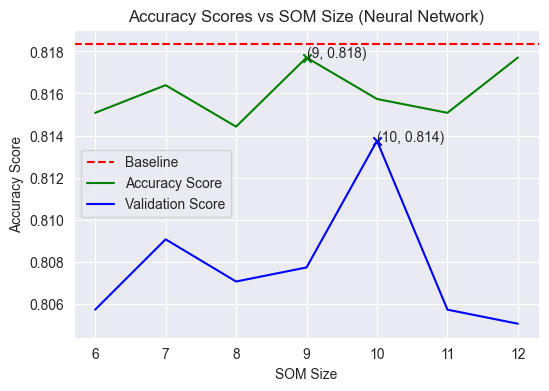

In [63]:
sizes_to_evaluate = [(6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12)]
model = KerasClassifier(
    create_model,
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    hidden_layer_dim=30,
    activ="tanh",
    verbose=0,
)
estimator = RandomForestClassifier()
estimator.fit(X_train, y_train)
train_pred_supervised = estimator.predict(X_train)
val_pred_supervised = estimator.predict(X_val)
test_pred_supervised = estimator.predict(X_test)
nn_test_acc_scores = []
nn_val_acc_scores = []

for size in sizes_to_evaluate:
    som = MiniSom(size[0], size[1], input_len=X_train_np.shape[1])
    som.random_weights_init(X_train_np)
    som.train_batch(X_train_np, num_iteration=100)

    X_train_pki = pki_transform(X_train_np, som, train_pred_supervised)
    X_val_pki = pki_transform(X_val_np, som, val_pred_supervised)

    X_train_pki_sample, _, y_train_sample, _ = train_test_split(
        X_train_pki, y_train, test_size=0.8, stratify=y_train
    )
    X_val_pki_sample, _, y_val_sample, _ = train_test_split(
        X_val_pki, y_val, test_size=0.8, stratify=y_val
    )

    X_test_pki = pki_transform(X_test_np, som, test_pred_supervised)

    model.fit(
        X_train_pki_sample,
        y_train_sample,
        epochs=100,
        validation_data=(X_val_pki_sample, y_val_sample),
    )

    nn_test_acc_scores.append(accuracy_score(y_test, model.predict(X_test_pki)))
    nn_val_acc_scores.append(accuracy_score(y_val, model.predict(X_val_pki)))

plot_best_n(
    [x[0] for x in sizes_to_evaluate],
    nn_test_acc_scores,
    nn_val_acc_scores,
    value="SOM Size",
    classifier="Neural Network",
    baseline=ensemble_baseline_accuracy["RF"][0],
    baseline_name = "Random Forest"
)

In [64]:
best_size = sizes_to_evaluate[np.argmax(nn_test_acc_scores)]

som = MiniSom(best_size[0], best_size[1], input_len=X_train_np.shape[1])
som.random_weights_init(X_train_np)
som.train_batch(X_train_np, num_iteration=100)

X_train_pki = pki_transform(X_train_np, som, train_pred_supervised)
X_val_pki = pki_transform(X_val_np, som, val_pred_supervised)
X_test_pki = pki_transform(X_test_np, som, test_pred_supervised)

X_train_pki_sample, _, y_train_sample, _ = train_test_split(
    X_train_pki, y_train, test_size=0.8, stratify=y_train
)
X_val_pki_sample, _, y_val_sample, _ = train_test_split(
    X_val_pki, y_val, test_size=0.8, stratify=y_val
)

params = {
    "hidden_layer_dim": [40, 50, 60],
    "batch_size": [32, 64],
    "optimizer": ["adam", "sgd"],
    "epochs": [100, 150, 200],
    "activ": ["relu", "tanh"],
}

model = KerasClassifier(
    create_model,
    loss="sparse_categorical_crossentropy",
    hidden_layer_dim=30,
    activ="tanh",
    verbose=0,
)

nn_grid = GridSearchCV(model, params, cv=3, verbose=1, n_jobs=-1)
nn_grid.fit(
    X_train_pki_sample,
    y_train_sample,
    validation_data=(X_val_pki_sample, y_val_sample),
)

print(f"Best Parameters: {nn_grid.best_params_}")
print(f"Best Accuracy: {nn_grid.best_score_}")

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Parameters: {'activ': 'tanh', 'batch_size': 32, 'epochs': 150, 'hidden_layer_dim': 50, 'optimizer': 'adam'}
Best Accuracy: 0.9897430353539324


Neural Network Accuracy: 0.824


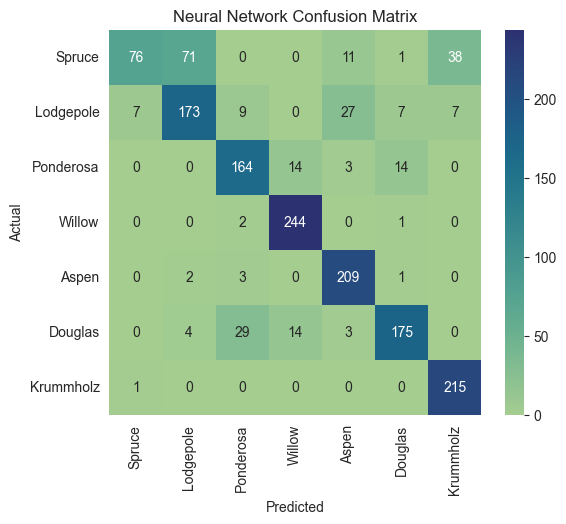

In [65]:
model = nn_grid.best_estimator_

model.fit(
    X_train_pki,
    y_train,
    validation_data=(X_val_pki, y_val),
)

y_pred = model.predict(X_test_pki)
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred):.3f}")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    cmap="crest",
    fmt="d",
    xticklabels=Cover_Type_Labels,
    yticklabels=Cover_Type_Labels,
)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()